## Load Libraries

In [1]:
!pip install nltk
!pip install gensim
!pip install boilerpy3
!pip install freediscovery

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#!pip install boilerpy3
#!pip install boilerpy3
#!pip install -I gensim
#!pip install -I smart_open
#!pip install --upgrade smart_open

import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import urllib
from urllib.request import urlopen
from boilerpy3 import extractors
import seaborn as sns
from IPython.display import display
from IPython.display import HTML

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import hamming_loss, rand_score, adjusted_rand_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

from datetime import datetime
import multiprocessing
from itertools import chain 

from freediscovery.feature_weighting import SmartTfidfTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Corpus

In [3]:
def process_docs(filename, headers=None):
    # Read in the entire corpus
    corpus = pd.read_json(filename, lines=True)
    
    return corpus

def clean_text(text, short_token_size = 4,):
    # split the tokens by whitespace
    tokens = text.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove the punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # Make tokens lowercase
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > short_token_size]
    # Lemmatization to account for things like plurals
    lem = WordNetLemmatizer()
    lem = [lem.lemmatize(token) for token in tokens]
    
    tokens = ' '.join(tokens)
    return tokens

def get_article(link):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    content = ''

    try:
        request=urllib.request.Request(link,None,headers) #The assembled request
        response = urllib.request.urlopen(request, timeout=10)
        data = response.read().decode('utf-8')
        extractor = extractors.ArticleExtractor()
        content = extractor.get_content(data)
    except:
        print('Unable to get content from: {}'.format(link))

    return content


def process_corpus(corpus):
    for i in range(len(corpus)):
        rowIndex = corpus.index[i]
        
        #corpus.loc[rowIndex, 'article_content'] = get_article(corpus['link'].iloc[i])
        #corpus.loc[rowIndex, 'article_content'] = clean_text(corpus.loc[rowIndex, 'article_content'])
        corpus.loc[rowIndex, 'headline'] = clean_text(corpus.loc[rowIndex, 'headline'])
        corpus.loc[rowIndex, 'short_description'] = clean_text(corpus.loc[rowIndex, 'short_description'])
        corpus.loc[rowIndex, 'text'] = corpus.loc[rowIndex, 'headline'] + ' ' + \
            corpus.loc[rowIndex, 'short_description']
        
        if (i % 1000 == 0):
            print('Completed: {}'.format(i))
    print('All Done!')
    return corpus

In [4]:
'would' in stopwords.words('english')

False

In [5]:
filename = 'News_Category_Dataset_v2.json'
# load corpus
corpus = process_docs(filename)

In [6]:
in_scope = ['POLITICS', 'ENTERTAINMENT', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES',\
           'FOOD & DRINK', 'BUSINESS']
corpus = corpus.loc[corpus['category'].isin(in_scope)].copy()

In [7]:
corpus

,category,headline,authors,link,short_description,date
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
...,...,...,...,...,...,...
200835,BUSINESS,Walmart Waving Goodbye To Some Greeters,,https://www.huffingtonpost.comhttp://jobs.aol....,"After 30 years, ""People Greeters"" will no long...",2012-01-28
200836,BUSINESS,"At World Economic Forum, Fear of Global Contag...","Peter S. Goodman, Contributor\nExecutive Busin...",https://www.huffingtonpost.com/entry/world-eco...,"For decades, as crises have assailed developin...",2012-01-28
200837,BUSINESS,Positive Customer Experience: What's the Retur...,"Ernan Roman, Contributor\nPresident",https://www.huffingtonpost.com/entry/positive-...,"""Analysts at Adobe combined historical purchas...",2012-01-28
200838,ENTERTAINMENT,"Sundance, Ice-T, and Shades of the American Ra...","Courtney Garcia, Contributor\nI tell stories a...",https://www.huffingtonpost.com/entry/sundance-...,Representation of the collective diaspora has ...,2012-01-28


In [8]:
#filename = 'News_Category_Dataset_v2.json'
# load corpus
#corpus = process_docs(filename)
# fix label
corpus.category = corpus.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

# get the content of each article using the link and clean the content, headline, and short description
# get 200 randomly sampled
encoder = LabelEncoder()
corpus['label'] = encoder.fit_transform(corpus['category'])
corpus_enhanced = process_corpus(corpus.sample(n=20000, random_state=37))
#corpus_enhanced = process_corpus(corpus)



# pickle file for later
pickle.dump(corpus, open('corpus_enhanced.p', 'wb'))

Completed: 0
Completed: 1000
Completed: 2000
Completed: 3000
Completed: 4000
Completed: 5000
Completed: 6000
Completed: 7000
Completed: 8000
Completed: 9000
Completed: 10000
Completed: 11000
Completed: 12000
Completed: 13000
Completed: 14000
Completed: 15000
Completed: 16000
Completed: 17000
Completed: 18000
Completed: 19000
All Done!


In [9]:
corpus_d = corpus_enhanced.reset_index()

In [10]:
corpus_d['category'].unique()

array(['POLITICS', 'FOOD & DRINK', 'TRAVEL', 'STYLE & BEAUTY',
       'ENTERTAINMENT', 'HEALTHY LIVING', 'PARENTING', 'QUEER VOICES',
       'BUSINESS'], dtype=object)

In [11]:
X = corpus_d['text']
y = corpus_d['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=37)

print('X_train: {}'.format (len(X_train)))
print('X_test {}'.format (len(X_test)))
print('y_train: {}'.format (len(y_train)))
print('y_test {}'.format (len(y_test)))

X_train: 16000
X_test 4000
y_train: 16000
y_test 4000


In [12]:
def create_dictionary(data, var_name):
    # get token counts and list
    tokens_dict = {}
    for ix in data.index:
        tokens_dict[ix] = {}
        c = Counter(data[ix].split())
        tokens_dict[ix]['tokens'] = list(c)
        tokens_dict[ix]['token_cnt'] = dict(c)
        
    # get vocabulary
    vocab = {}
    token_threshold = 5
    for doc in tokens_dict.keys():
        vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= token_threshold]
    vocab_list = list()
    for doc in vocab.keys():
        for word in vocab[doc]:
            vocab_list.append(word)
    vocab_list = list(np.unique(vocab_list))
    print('{} Vocabulary Size: {}'.format(var_name, len(vocab_list)))
    
    output = {'text': data, 'tokens_dict': tokens_dict, 'vocab_list': vocab_list}
    
    return output

In [13]:
X_train_data = create_dictionary(X_train, 'X_train')
X_test_data = create_dictionary(X_test, 'X_test')

X_train Vocabulary Size: 25
X_test Vocabulary Size: 7


## Analysis Functions

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def get_kmeans(X, y):
    n_clusters = len(np.unique(y))
    kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100000)
    X_kmeans = kmeans_model.fit(X)
    kmeans_labels = kmeans_model.labels_.tolist()
    
    return kmeans_model, kmeans_labels
    
def get_cluster_scatter_plot(X, kmeans_model, kmeans_labels, title):
    pca = PCA(n_components=2).fit(X)
    datapoint = pca.transform(X)

    plt.figure(figsize=(10, 6))
    label1 = ['#DFFF00', '#FFBF00', '#FF7F50', '#DE3163', '#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF', '#999999', '#0000FF']#, "#0000FF"]
    color = [label1[i] for i in kmeans_labels]
    scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.title(title + ' PCA Cluster Plot')
    plt.show()
    
def evaluate_cluster_performance(model, X_train, y_train, X_test, y_test):
    # train
    y_train_pred = model.predict(X_train)
    #print('hamming loss train: {}'.format(hamming_loss(y_train, y_train_pred)))
    #print('train rand_score: {}'.format(metrics.rand_score(y_train, y_train_pred)))
    print('train adjusted_rand_score: {}'.format(metrics.adjusted_rand_score(y_train, y_train_pred)))

    # test
    y_test_pred = model.predict(X_test)
    #print('test rand_score: {}'.format(metrics.rand_score(y_test, y_test_pred)))
    print('test adjusted_rand_score: {}'.format(metrics.adjusted_rand_score(y_test, y_test_pred)))

In [15]:
X_train_data['text']

5862     michelle obamas inauguration wanting swing pho...
5828     pixar kiddie packaging cringeworthy photoshop ...
13469    great british baking judge berry arrested airp...
2719     tyler chrissy teigen stars stella mccartneys p...
17822    therapy couch bodies instinctively selfheal ch...
                               ...                        
11898    trump urges republican senators healthcare rep...
4118     plane ticket found useful might passing along ...
988      behind scenes fascinating controversial street...
9036     observations roman observe million people beau...
1935     coming immigration trumps america great degree...
Name: text, Length: 16000, dtype: object

In [16]:
ngram_range = (1,3)

In [220]:
label_indexes = {}
for label in np.unique(y_train):
    ix = y_train[y_train==label].index
    label_indexes.update({label: {'name': encoder.inverse_transform([label])[0], 'indexes': ix}})

## Manual Word Vector

In [240]:
from sklearn.feature_extraction.text import CountVectorizer

In [64]:
#KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100000)
pipeline = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('clf', KMeans(init='k-means++')),
    #('clf', OneVsRestClassifier(MultinomialNB(
    #    fit_prior=True, class_prior=None))),
])
parameters = {
    'cv__max_df': np.arange(0.1, 1.1, 0.05),
    'cv__min_df': np.arange(1, 1001, 100),
    'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cv__max_features': [8000],
    'clf__n_clusters': [9],
    'clf__max_iter': [100000]
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=8, verbose=4)
grid_search_tune.fit(X_train_data['text'], y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 600 candidates, totalling 1200 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [-84831.37989448 -87633.17157993 -87814.58610796  -8750.35338957
  -8779.14162493  -8795.98573608   -904.34934673   -939.64976762
   -929.99360581   -113.12823144   -113.05446464   -113.05760018
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.                     nan             nan             nan
             nan             nan             nan             nan
             nan             nan -85003.66220993 -87570.48678778
 -87614.55925398  -8685.24814557  -8909.84356581  -8952.35818183
   -940.03323025   -935.3665087    -935.94083043   -113.14930104
   -113.05446464   -113.03200302      0.              0.
      0.              0.              0.              0.
      0.              0.              0.                     nan
             nan             nan             nan

Best parameters set:
[('cv', CountVectorizer(max_df=0.1, max_features=8000, min_df=401, stop_words='english')), ('clf', KMeans(max_iter=100000, n_clusters=9))]


In [241]:
ngram_range = (1,3)
min_df = 401
max_df = 0.1


vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df, stop_words="english",)
matrix = vec.fit_transform(X_train_data['text'])
XTrain = matrix.toarray()
XTest = vec.transform(X_test_data['text']).toarray()

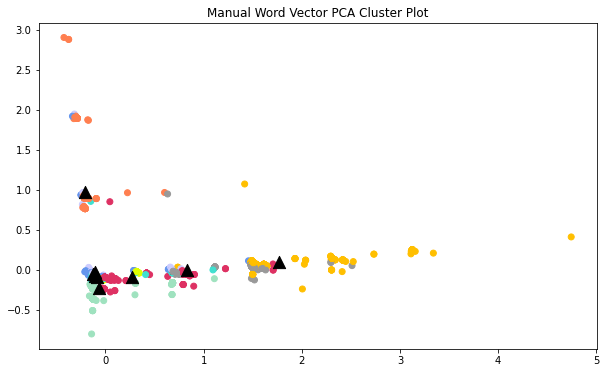

train adjusted_rand_score: -0.007614041804533967
test adjusted_rand_score: -0.005278588383632671


In [242]:
# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'Manual Word Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

In [243]:
sum_words = matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq

[('trump', 1664),
 ('photos', 1144),
 ('people', 820),
 ('donald', 760),
 ('donald trump', 587),
 ('world', 556),
 ('president', 556),
 ('video', 535),
 ('years', 498),
 ('house', 435)]

In [260]:
label_important_words = {}

for label, value in label_indexes.items():
    vec = CountVectorizer(ngram_range=(1,2), stop_words='english')
    matrix = vec.fit_transform(X_train_data['text'][value['indexes']])
    
    sum_words = matrix.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(words_freq)
    
    df = df.drop_duplicates()
    df = df.rename(columns={0:'word', 1: 'count'})
    label_important_words.update({value['name']: df})

#array(['POLITICS', 'FOOD & DRINK', 'TRAVEL', 'STYLE & BEAUTY',
#       'ENTERTAINMENT', 'HEALTHY LIVING', 'PARENTING', 'QUEER VOICES',
#       'BUSINESS'], dtype=object)

In [262]:
label_important_words['BUSINESS'][0:20]

,word,count
0,business,123
1,people,76
2,women,70
3,company,49
4,workers,43
5,companies,42
6,change,41
7,years,34
8,industry,33
9,world,31


## TF-IDF

In [257]:
#KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100000)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', KMeans(init='k-means++')),
    #('clf', OneVsRestClassifier(MultinomialNB(
    #    fit_prior=True, class_prior=None))),
])
parameters = {
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__max_df': [0.95],
    'tfidf__min_df': [5],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True, False],
    'tfidf__use_idf': [True, False],
    'tfidf__strip_accents': [None, 'ascii', 'unicode'],
    'tfidf__max_features': [8000],
    #'clf__estimator__alpha': (1e-2, 1e-3)
    'clf__n_clusters': [9],
    'clf__max_iter': [100000]
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=8, verbose=4)
grid_search_tune.fit(X_train_data['text'], y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.95, max_features=8000, min_df=5, ngram_range=(1, 3),
                norm='l1', smooth_idf=False, stop_words='english',
                strip_accents='ascii', sublinear_tf=True, use_idf=False)), ('clf', KMeans(max_iter=100000, n_clusters=9))]


In [258]:
# best parameters
max_df = 0.05
max_features=8000
min_df = 5
ngram_range = (1,3)
norm = 'l1'
smooth_idf=True
stop_words='english'
strip_accents='ascii'
sublinear_tf=True
use_idf=False


tfidf = TfidfVectorizer(ngram_range=ngram_range, norm=norm, max_df=max_df, min_df=min_df, sublinear_tf=sublinear_tf, \
                        stop_words=stop_words, max_features=max_features, strip_accents=strip_accents, use_idf=use_idf, \
                       smooth_idf=smooth_idf)
XTrain = tfidf.fit_transform(X_train_data['text']).toarray()
XTest = tfidf.transform(X_test_data['text']).astype('float64').toarray()

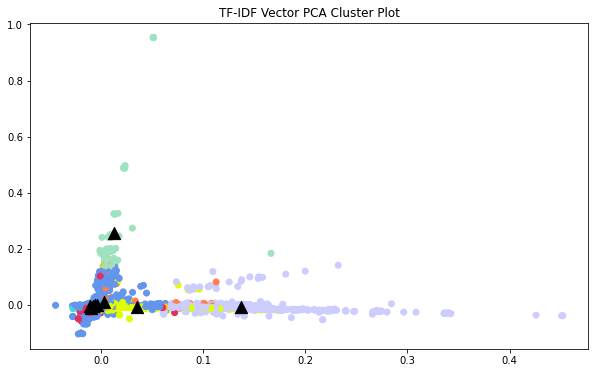

train adjusted_rand_score: -0.032896877218783864
test adjusted_rand_score: -0.03177079706087411


In [259]:
# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'TF-IDF Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

In [58]:
tfidf = TfidfVectorizer(ngram_range=ngram_range, min_df=5, max_df=0.95, max_features=8000)
XTrain = tfidf.fit_transform(X_train_data['text']).toarray()
XTest = tfidf.transform(X_test_data['text']).astype('float64').toarray()

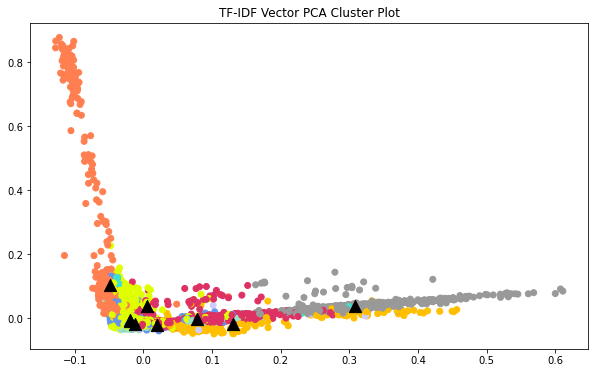

train adjusted_rand_score: -0.023509218060891447
test adjusted_rand_score: -0.020863427058684426


In [59]:
# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'TF-IDF Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

In [68]:
# best parameters
max_df = 0.3
min_df = 371
norm = 'l1'
stop_words='english'
ngram_range = (1,3)
strip_accents=None
sublinear_tf=True
max_features=8000

tfidf = TfidfVectorizer(ngram_range=ngram_range, norm=norm, max_df=max_df, min_df=min_df, sublinear_tf=sublinear_tf, \
                        stop_words=stop_words, max_features=max_features, strip_accents=strip_accents)
XTrain = tfidf.fit_transform(X_train_data['text']).toarray()
XTest = tfidf.transform(X_test_data['text']).astype('float64').toarray()

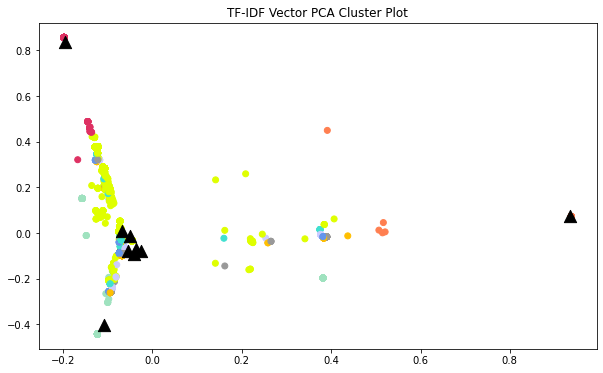

train adjusted_rand_score: 0.02206494380684275
test adjusted_rand_score: 0.02462504720157772


In [69]:
# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'TF-IDF Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

In [263]:
label_important_words = {}
for label, value in label_indexes.items():
    tfidf = TfidfVectorizer(ngram_range=ngram_range, norm=norm, sublinear_tf=sublinear_tf, \
                        stop_words=stop_words, max_features=max_features, strip_accents=strip_accents)
    XTrain = tfidf.fit_transform(X_train_data['text'][value['indexes']])
    
    feature_names = tfidf.get_feature_names()
    feature_ix = XTrain[0:].nonzero()[1]
    tfidf_scores = zip(feature_ix, [XTrain[0, x] for x in feature_ix])
    
    df = pd.DataFrame(columns=['word', 'tf-idf score'])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        if s > 0.0:
            df = df.append({'word': w, 'tf-idf score': s}, ignore_index=True)
    df.sort_values(by=['tf-idf score'], axis=0, inplace=True, ascending=False)
    df = df.drop_duplicates()
    label_important_words.update({value['name']: df})

#array(['POLITICS', 'FOOD & DRINK', 'TRAVEL', 'STYLE & BEAUTY',
#       'ENTERTAINMENT', 'HEALTHY LIVING', 'PARENTING', 'QUEER VOICES',
#       'BUSINESS'], dtype=object)

In [264]:
label_important_words['BUSINESS'][0:20]

,word,tf-idf score
25,customer,0.070865
111,customer service,0.066358
13,customer loyalty,0.061446
81,loyalty,0.055463
53,service,0.053266
1,manage customer loyalty,0.036291
0,loyalty build relationships,0.036291
3,management customer service,0.036291
4,loyalty management customer,0.036291
5,relationships customers,0.036291


## doc2vec Vector

In [254]:
doc2vec_corpus = list()
for doc in X_train_data['text']:
    c = Counter(doc.split())
    doc2vec_corpus.append(list(c))
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]

doc2vec_corpus_test = list()
for doc in X_test_data['text']:
    c = Counter(doc.split())
    doc2vec_corpus_test.append(list(c))
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]

epochs = 10   # How many epochs to be trained
vector_size = 500  # How many dimensions
alpha = .025   # Initial learning rate
min_alpha = .00025  # Learning rate changes step
dm = 1   # Use Distributed bags of words

doc2vec_model = Doc2Vec(vector_size=vector_size, window=10, min_count=1, workers=16, seed=111)
doc2vec_model.build_vocab(documents)

doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=15)
print('Finished model training process')

Finished model training process


In [62]:
X_test = list()
for doc in doc2vec_corpus_test:
    X_test.append(doc2vec_model.infer_vector(doc))
X_test = np.array(X_test)
X_test.shape

(4000, 500)

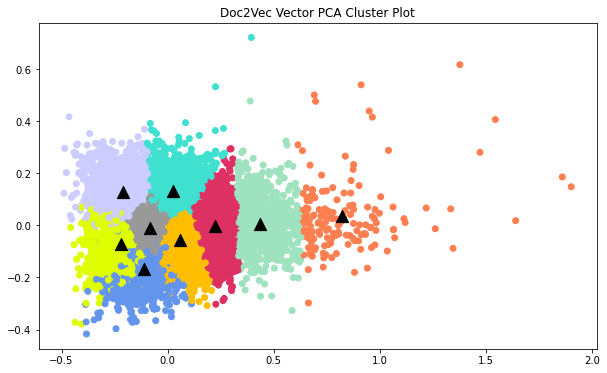

train adjusted_rand_score: 0.09722289164480423
test adjusted_rand_score: 0.13898874615123932


In [63]:
XTrain = doc2vec_model.docvecs.vectors_docs
XTest = X_test

# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'Doc2Vec Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

In [253]:
doc2vec_corpus = list()
for doc in X_train_data['text']:
    c = Counter(doc.split())
    doc2vec_corpus.append(list(c))
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]

doc2vec_corpus_test = list()
for doc in X_test_data['text']:
    c = Counter(doc.split())
    doc2vec_corpus_test.append(list(c))
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]

In [252]:
from sklearn.base import BaseEstimator
class Doc2VecModel(BaseEstimator):

    def __init__(self, dm=1, size=1, window=1):
        self.d2v_model = None
        self.size = size
        self.window = window
        self.dm = dm

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.d2v_model = Doc2Vec(size=self.size, window=self.window, dm=self.dm, iter=5, alpha=0.025, min_alpha=0.001)
        # Tag docs
        tagged_documents = []
        for index, row in raw_documents.iteritems():
            tag = '{}_{}'.format("type", index)
            tokens = row.split()
            tagged_documents.append(TaggedDocument(words=tokens, tags=[tag]))
        # Build vocabulary
        self.d2v_model.build_vocab(tagged_documents)
        # Train model
        self.d2v_model.train(tagged_documents, total_examples=len(tagged_documents), epochs=self.d2v_model.iter)
        return self

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
            X.append(self.d2v_model.infer_vector(row))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X

    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)

In [255]:
pipeline = Pipeline([
    ('doc2vec', Doc2VecModel()),
    ('clf', KMeans(init='k-means++')),
    #('clf', OneVsRestClassifier(MultinomialNB(
    #    fit_prior=True, class_prior=None))),
])

epochs = 10   # How many epochs to be trained
vector_size = 500  # How many dimensions
alpha = .025   # Initial learning rate
min_alpha = .00025  # Learning rate changes step
dm = 1   # Use Distributed bags of words

parameters = {
    'doc2vec__window': np.arange(2, 11, 1),
    'doc2vec__size': np.arange(100, 1001, 100),
    'doc2vec__dm': np.arange(1, 5, 1),
    #'clf__estimator__alpha': (1e-2, 1e-3)
    'clf__n_clusters': [9],
    'clf__max_iter': [100000]
}

kmean_grid = GridSearchCV(pipeline, 
                        param_grid=parameters,
                        scoring="accuracy",
                        verbose=4,
                        n_jobs=8)

fitted = kmean_grid.fit(X_train_data['text'], y_train)

# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

TypeError: Parameter doc_words of infer_vector() must be a list of strings (not a single string).